# Meeter Detection

**Few Shot Object Detection for TensorFlow Lite**. Here, we  fine tuning of a SSD architecture (pre-trained on COCO) on very few examples of electricity meeter. We will then generate a (downloadable) TensorFlow Lite model for on-device inference.

### Cleanup


*   Delete training data dir
*   Unzip latest training data from training_data.zip



In [1]:
!rm -rf ./output
!rm -rf ./training_data
#!unzip -q training_data.zip

# Set Up

#### Download training_data.zip from google drive
Replace "1F1IDwTSe9sVCIdjXsOhzYYoxbDe3tO3N" with file id from google drive. 
You can get file id by sharing the file as "Any one with link" and get id form link.
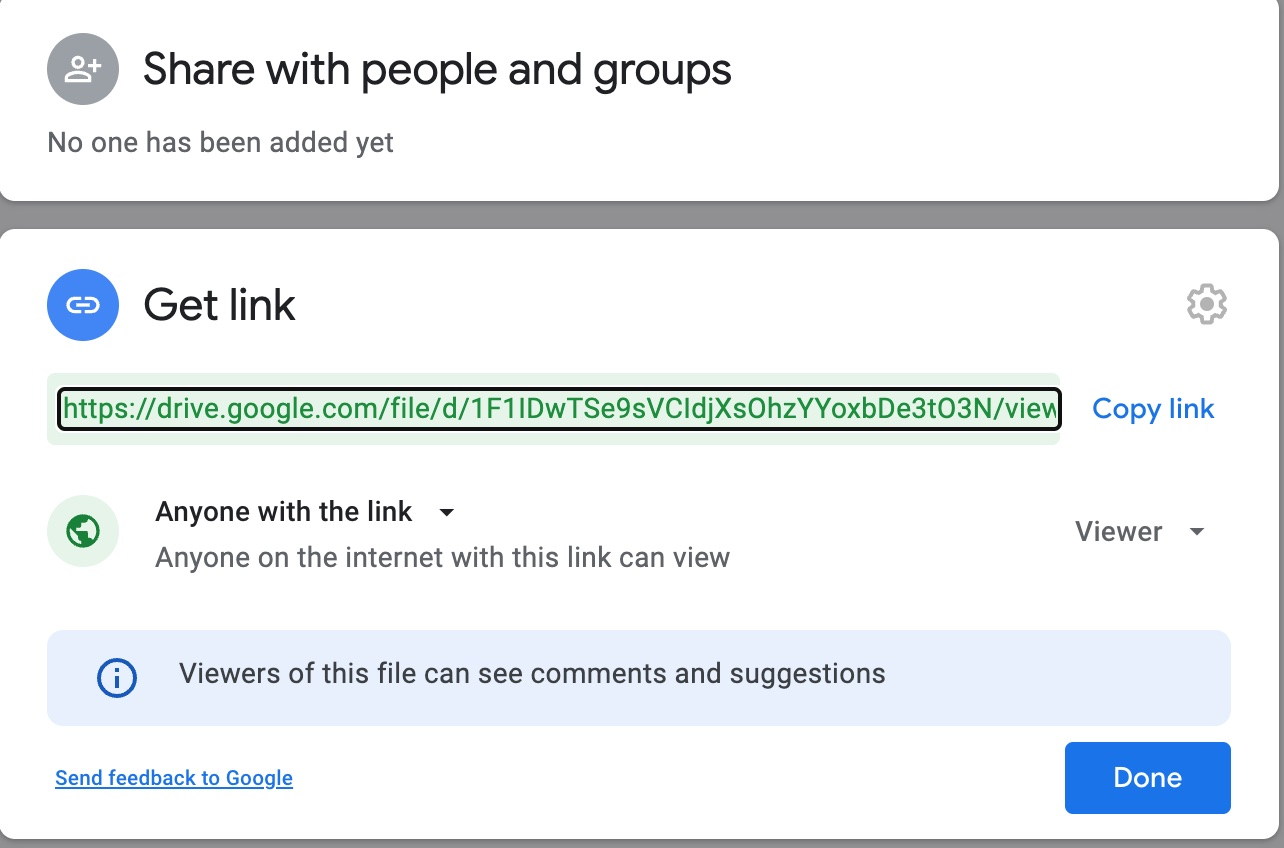

In [1]:
import os
from os.path import exists, join, basename, splitext

training_data = 'training_data'
if not exists(training_data):
  training_data_file_name = 'training_data.zip'
  !gdown --id 1F1IDwTSe9sVCIdjXsOhzYYoxbDe3tO3N
  !unzip -qq $training_data_file_name

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1F1IDwTSe9sVCIdjXsOhzYYoxbDe3tO3N
To: /content/training_data.zip
100% 38.1M/38.1M [00:00<00:00, 71.3MB/s]


## Imports

In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 3336, done.
remote: Counting objects: 100% (3336/3336), done.
remote: Compressing objects: 100% (2772/2772), done.
remote: Total 3336 (delta 880), reused 1412 (delta 514), pack-reused 0
Receiving objects: 100% (3336/3336), 34.33 MiB | 30.30 MiB/s, done.
Resolving deltas: 100% (880/880), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install -qq .
python -m pip install -qq opencv-python-headless==4.1.2.30

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import csv
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
from pathlib import Path

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

##Utilities

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=1,
      min_score_thresh=0.3)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


### Load data


Load training data

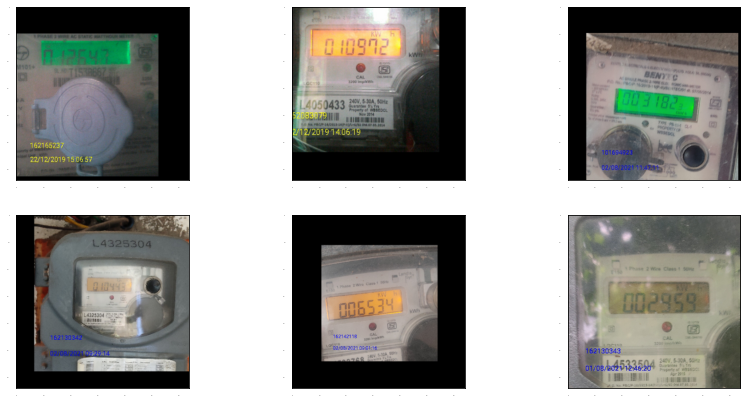

In [6]:
# Load images and visualize
train_image_dir = './training_data/train/'
train_images_np = []
train_gt_boxes = []
for image_path in glob.iglob(train_image_dir + '*.png'):
  train_images_np.append(load_image_into_numpy_array(image_path))

  train_gt_path = image_path.replace('.png', '-bbox.txt')
  with open(train_gt_path, 'r') as f:
    reader = csv.reader(f)
    bbox_np = []
    for row in reader:
      #Contains detection boxes coordinates in format [y_min, x_min, y_max, x_max],
      #where (x_min, y_min) are coordinates of the top left corner,
      #(x_max, y_max) are coordinates of the right bottom corner
      bbox_np.append([float(row[1]), float(row[2]), float(row[3]), float(row[4])])
    train_gt_boxes.append(np.array(bbox_np, dtype=np.float32))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np[:6]):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

Load testing data

In [7]:
test_image_dir = './training_data/test/'
test_images_np = []
test_gt_boxes = []
for image_path in glob.iglob(test_image_dir + '*.png'):
  test_images_np.append(load_image_into_numpy_array(image_path))

  test_gt_path = image_path.replace('.png', '-bbox.txt')
  with open(test_gt_path, 'r') as f:
    reader = csv.reader(f)
    bbox_np = []
    for row in reader:
      #Contains detection boxes coordinates in format [y_min, x_min, y_max, x_max],
      #where (x_min, y_min) are coordinates of the top left corner,
      #(x_max, y_max) are coordinates of the right bottom corner
      bbox_np.append([float(row[1]), float(row[2]), float(row[3]), float(row[4])])
    test_gt_boxes.append(np.array(bbox_np, dtype=np.float32))

In [8]:
assert(len(train_images_np) == len(train_gt_boxes))
assert(len(test_images_np) == len(test_gt_boxes))

print(f'Number of training images: {len(train_images_np)}')
print(f'Number of test images: {len(test_images_np)}')

Number of training images: 273
Number of test images: 23


# Transfer Learning


## Data Preparation

First, we populate the groundtruth with pre-annotated bounding boxes.

We then add the class annotations.  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [9]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
digital_class_id = 1
num_classes = 1

category_index = {digital_class_id: {'id': digital_class_id, 'name': 'digital'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, train_gt_box_np) in zip(
    train_images_np, train_gt_boxes):
  # train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
  #     train_image_np, dtype=tf.float32), axis=0))
  train_image_tensors.append(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32))
  gt_box_tensors.append(tf.convert_to_tensor(train_gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[train_gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
  

test_image_tensors = []
test_gt_classes_one_hot_tensors = []
test_gt_box_tensors = []
for (test_image_np, test_gt_box_np) in zip(
    test_images_np, test_gt_boxes):
  test_image_tensors.append(tf.convert_to_tensor(
      test_image_np, dtype=tf.float32))
  test_gt_box_tensors.append(tf.convert_to_tensor(test_gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[test_gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  test_gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')


Done prepping data.


Let's just visualize the training data as a sanity check


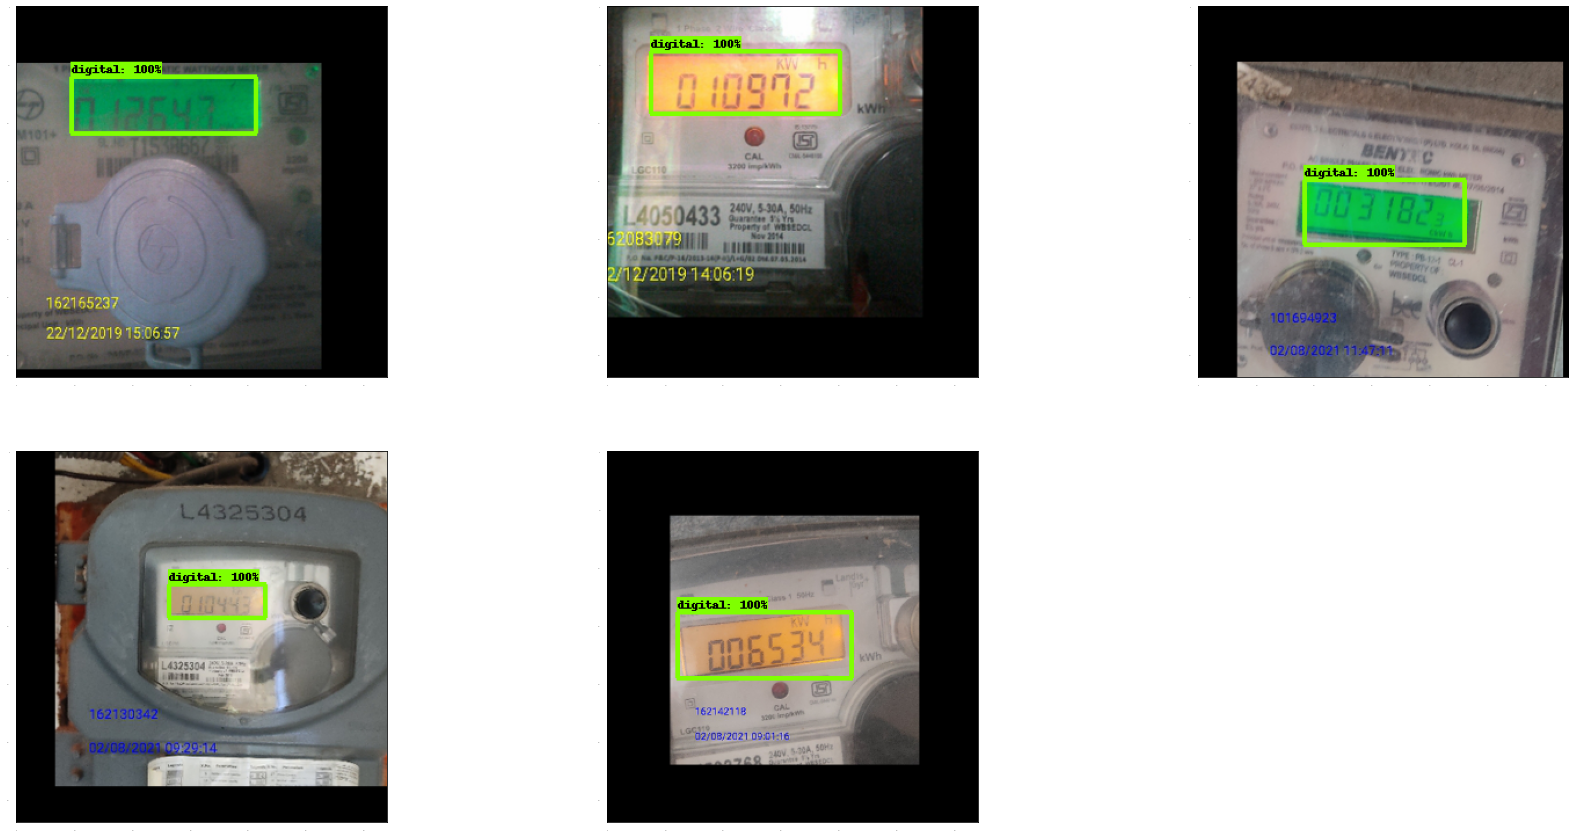

In [10]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      train_gt_boxes[idx],
      np.ones(shape=[train_gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

## Load mobile-friendly model

In this cell we build a mobile-friendly single-stage detection architecture (SSD MobileNet V2 FPN-Lite) and restore all but the classification layer at the top (which will be randomly initialized).

**NOTE**: TensorFlow Lite only supports SSD models for now.



In [11]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-05-08 07:26:37--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.120.128, 2607:f8b0:4001:c18::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.120.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.1s    

2022-05-08 07:26:37 (171 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]



In [12]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
# Save new pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# Set up object-based checkpoint restore --- SSD has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# To save checkpoint for TFLite conversion.
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 320, 320, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
INFO:tensorflow:Writing pipeline config file to output/pipeline.config
Weights restored!


### Augmentation

In [13]:
def tf_augment(image, seed, p=0.2):
  """
  # p,  probablity that an augmentation is applied to an image.
        when p = 0.20, there is 32% chance that no augmenation is applied
  """

  #image = tf.squeeze(image, axis=1)
  
  # Random contrast.
  if  tf.random.uniform([]) < p:
    image = tf.image.stateless_random_contrast(image, 0.7, 1.3, seed)
  
  # Random saturation.
  if  tf.random.uniform([]) < p:
    image = tf.image.stateless_random_saturation(image, 0.7, 1.3, seed)

  # Random brightness.
  if  tf.random.uniform([]) < p:
    image = tf.image.stateless_random_brightness(image, 0.2, seed)

  # Random hue.
  if  tf.random.uniform([]) < p:
    image = tf.image.stateless_random_hue(image, 0.1, seed)

  # Random jpeg quality.
  # if  tf.random.uniform([]) < p:
  #   image = tf.image.stateless_random_jpeg_quality(image, 70, 95, seed)  

  #image = tf.expand_dims(image, axis=1)
  return image


import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        # iaa.Fliplr(0.5), # horizontally flip 50% of all images
        # iaa.Flipud(0.2), # vertically flip 20% of all images
        # # crop images by -5% to 10% of their height/width
        # sometimes(iaa.CropAndPad(
        #     percent=(-0.05, 0.1),
        #     pad_mode=ia.ALL,
        #     pad_cval=(0, 255)
        # )),
        # sometimes(iaa.Affine(
        #     scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
        #     translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
        #     rotate=(-45, 45), # rotate by -45 to +45 degrees
        #     shear=(-16, 16), # shear by -16 to +16 degrees
        #     order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
        #     cval=(0, 255), # if mode is constant, use a cval between 0 and 255
        #     mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        # )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 3),
            [
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    #iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                #iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                #iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
            ],
            random_order=True
        )
    ],
    random_order=True
  )

def augment(images):
  ia.seed(random.randint(0, 9999999))
  images_aug = seq(images=images.numpy())  
  
  return images_aug

## Eager training loop (Fine-tuning)






In [15]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned
batch_size = 12
learning_rate = 0.015
num_epochs = 2000
num_examples = len(train_image_tensors)

# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 320x320.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[320, 320, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      # preprocessed_images = tf.concat(
          # [detection_model.preprocess(image_tensor)[0]
          #  for image_tensor in image_tensors], axis=0)
      preprocessed_images = detection_model.preprocess(image_tensors)[0]
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
loss_history = []
for epoch in range(num_epochs):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  for batch in range(0, num_examples, batch_size):
    example_keys = all_keys[batch: batch + batch_size]

    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = tf.convert_to_tensor([train_image_tensors[key] for key in example_keys], dtype=tf.float32)

    #augmentation
    seed = rng.make_seeds(2)[0]
    #image_tensors = tf_augment(image_tensors, seed)
    image_tensors = augment(image_tensors)

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
    loss_history.append(total_loss.numpy())

  if epoch % 100 == 0:
    test_loss_history = []
    test_all_keys = list(range(len(test_images_np)))

    for test_batch in range(0, len(test_image_tensors), batch_size):
      example_keys = test_all_keys[test_batch: test_batch + batch_size]

      gt_boxes_list = [test_gt_box_tensors[key] for key in example_keys]
      gt_classes_list = [test_gt_classes_one_hot_tensors[key] for key in example_keys]
      image_tensors = tf.convert_to_tensor([test_image_tensors[key] for key in example_keys], dtype=tf.float32)

      total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
      test_loss_history.append(total_loss.numpy())

    print('Epoch ' + str(epoch) + ' of ' + str(num_epochs)
    + ', loss=' +  str(sum(loss_history)/len(loss_history))
    + ', validdation loss=' +  str(sum(test_loss_history)/len(test_loss_history)), flush=True)
    loss_history = []

print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

Start fine-tuning!


/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Epoch 0 of 200, loss=0.70173848711926, validdation loss=0.7256617844104767
Epoch 100 of 200, loss=0.48006121452735817, validdation loss=0.49497997760772705
Done fine-tuning!
Checkpoint saved!


# Export & run with TensorFlow Lite



## Model Conversion

First, we invoke the `export_tflite_graph_tf2.py` script to generate a TFLite-friendly intermediate SavedModel. This will then be passed to the TensorFlow Lite Converter for generating the final model.

To know more about this process, please look at [this documentation](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md).

In [16]:
%%bash
python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path output/pipeline.config \
  --trained_checkpoint_dir output/checkpoint \
  --output_directory tflite

2022-05-08 07:42:10.932108: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-08 07:42:19.368297: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
W0508 07:42:21.306661 140352153794432 save_impl.py:72] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7fa53c319b90>, because it is not built.
W0508 07:42:21.556498 140352153794432 save_impl.py:72] Skipping full serialization of Keras layer <keras.layers.convolutional.SeparableConv2D object at 0x7fa53c275ed0>, because it is not built.
W0508 07:42:21.556722 140352153794432 save_impl.py:72] Skipping full serialization of Keras layer <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x7fa5263ce210>, because 

In [17]:
!tflite_convert --saved_model_dir=tflite/saved_model --output_file=tflite/model.tflite

2022-05-08 07:42:47.268861: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-08 07:42:56.525740: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-08 07:42:56.525799: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
Estimated count of arithmetic ops: 1.698 G  ops, equivalently 0.849 G  MACs
W0508 07:42:59.341415 140698291275648 lite.py:770] Buffer deduplication procedure will be skipped when flatbuffer library is not properly loaded


## Test .tflite model

Cleanup the prediction folder

In [18]:
import shutil
shutil.rmtree("./prediction", ignore_errors=True)
Path("./prediction").mkdir(parents=True, exist_ok=True)

Run prediction on test images

In [19]:
test_image_dir = './training_data/test/'
test_images_np = []
test_images_path = []
for image_path in glob.iglob(test_image_dir + '*.png'):
  test_images_path.append(image_path)
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))


# Again, uncomment this decorator if you want to run inference eagerly
def detect(interpreter, input_tensor):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[1]['index'])
  classes = interpreter.get_tensor(output_details[3]['index'])
  scores = interpreter.get_tensor(output_details[0]['index'])
  return boxes, classes, scores

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = detect(interpreter, input_tensor)
  image_name = "./prediction/" + Path(test_images_path[i]).name.replace('.jpeg', '-predict.jpeg')
  
  plot_detections(
      test_images_np[i][0],
      boxes[0],
      classes[0].astype(np.uint32) + label_id_offset,
      scores[0],
      category_index,
      figsize=(15, 20),
      image_name=image_name
    )

Display predictions

In [20]:
predictions = glob.glob('./prediction/*.jpeg')
plt.figure(figsize=(100, 400))
for idx in range(len(predictions)):
  plt.subplot(10, 3, idx+1)
  image = load_image_into_numpy_array(predictions[idx])
  plt.imshow(image)

<Figure size 7200x28800 with 0 Axes>

## Download model

This model can be run on-device with **TensorFlow Lite**. Look at [our SSD model signature](https://www.tensorflow.org/lite/models/object_detection/overview#uses_and_limitations) to understand how to interpret the model IO tensors. Our [Object Detection example](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection) is a good starting point for integrating the model into your mobile app.

Refer to TFLite's [inference documentation](https://www.tensorflow.org/lite/guide/inference) for more details.

In [21]:
from google.colab import files
files.download('tflite/model.tflite') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>